In [37]:
import wget
import requests
import pandas as pd
import os
from time import sleep
import tqdm
from dataclasses import dataclass
import datetime

In [54]:
LINK = "https://pkb.mpi-inf.mpg.de/reddust_data/gender.txt"
OUTPUT_FILE = "../../data/red_dust/gender.txt"

In [38]:
# # download
# os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
# wget.download(LINK, OUTPUT_FILE)

In [55]:
df = pd.read_csv(OUTPUT_FILE, sep="\t", names=["attr", "user_id", "value", "cid"])

In [41]:
@dataclass
class RedditCommentInfo:
    text: str
    subreddit: str
    is_post: bool
    username: str
    permalink: str
    created_utc: datetime.datetime
    title: str | None=None
    deleted: bool = False

In [42]:
def get_reddit_comment_data(cid: str, kind: str, delay=0):
    if delay > 0:
        sleep(delay)
    url = f"https://www.reddit.com/api/info.json?id={kind}_{cid}"
    headers = {"User-Agent": "comment-fetcher"}

    try:
        data = requests.get(url, headers=headers).json()
    except Exception as e:
        print(f"Error fetching data for {cid}: {e}")
        print(requests.get(url, headers=headers))
        return None
    data = [x for x in data["data"]["children"] if x["kind"] == kind]
    if len(data) == 0:
        return None
    data = data[0]["data"]
    created_time = datetime.datetime.fromtimestamp(data["created_utc"])
    if data["author"].strip().lower() == "[deleted]" or (
        "selftext" in data and data["selftext"].strip().lower() in ["[deleted]", "[removed]"]
    ):
            return RedditCommentInfo(
                text="",
                subreddit=data["subreddit"],
                username="",
                created_utc=created_time,
                is_post=kind == "t3",
                permalink="",
                deleted=True
            )
    if kind == "t1": # comment
        return RedditCommentInfo(
            text=data["body"],
            username=data["author"],
            subreddit=data["subreddit"],
            permalink=data["permalink"],
            created_utc=created_time,
            is_post=False,
        )
    RedditCommentInfo(
            title=data["title"],
            text=data["selftext"],
            username=data["author"],
            subreddit=data["subreddit"],
            permalink=data["permalink"],
            created_utc=created_time,
            is_post=False,
        )

def extract_comment_info(cid: str, delay=0.1):
    # first see if this is a comment
    num_requests = 1
    data = get_reddit_comment_data(cid, "t1", delay=delay)
    if data is None:
        data = get_reddit_comment_data(cid, "t3", delay=delay)
        num_requests = 2
    return (data if data is not None and not data.deleted else None), num_requests

In [60]:
extract_comment_info(df.loc[6000]["cid"])

(RedditCommentInfo(text='This one caught my eye too, I immediately had to share it on facebook once I saw his original post. Such style, such execution.', subreddit='glassheads', is_post=False, username='0gonzo0', permalink='/r/glassheads/comments/1qene9/jred_glasss_rainbow_filla_rig/cdccpjs/', created_utc=datetime.datetime(2013, 11, 11, 21, 30, 2), title=None, deleted=False),
 1)

In [ ]:
def get_authors(df, request_limit=20, delay=0.1):
    authors = {}
    n_requests = 0
    users = df["user_id"].unique()
    
    progress = tqdm.tqdm(total=request_limit if request_limit is not None else len(users))
    for user in users:
        cids = df[df["user_id"] == user]["cid"]
        for cid in cids:
            if request_limit is not None and \
                    n_requests >= request_limit - 2:
                return authors
            data, reqs = extract_comment_info(cid, delay=delay)
            n_requests += reqs
            if request_limit is not None:
                progress.update(reqs)
            else:
                progress.update()
            
            if data is None:
                continue
            authors[user] = data.username
            break
    return authors

In [28]:
gender_authors = get_authors(df)

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [00:05<00:00,  3.36it/s]


In [29]:
gender_authors

{np.int64(1): '---------throwaway',
 np.int64(2): '-------jem',
 np.int64(3): '----hey',
 np.int64(4): '---Butter---',
 np.int64(5): '---sigma',
 np.int64(6): '--Llama--',
 np.int64(7): '--_--ThrowAway--__--',
 np.int64(8): '--__-',
 np.int64(9): '--anna-',
 np.int64(10): '--n0pe--',
 np.int64(11): '--temporary',
 np.int64(12): '-Admiral_Piett-'}

In [16]:
LINK = "https://pkb.mpi-inf.mpg.de/reddust_data/age.txt"
OUTPUT_FILE = "../../data/red_dust/age.txt"
# download
# os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
# wget.download(LINK, OUTPUT_FILE)

In [17]:
age_df = pd.read_csv(OUTPUT_FILE, sep="\t", names=["attr", "user_id", "value", "cid"])

(array([ 300218., 3130354., 1628155.,  454692.,  122727.,   49868.,
          27030.,   13686.,    6179.,   69026.]),
 array([ 6. , 15.3, 24.6, 33.9, 43.2, 52.5, 61.8, 71.1, 80.4, 89.7, 99. ]),
 <BarContainer object of 10 artists>)

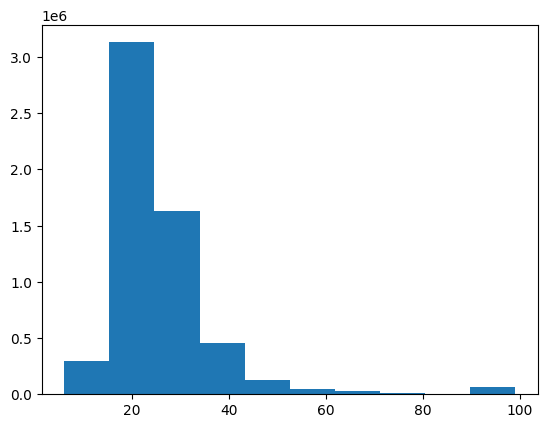

In [62]:
import matplotlib.pyplot as plt
plt.hist(age_df["value"])

In [18]:
age_authors = get_authors(age_df)

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [00:05<00:00,  3.12it/s]


In [19]:
age_authors

{np.int64(1): '--------x---------',
 np.int64(2): '---JT---',
 np.int64(3): '---__---',
 np.int64(4): '--314--',
 np.int64(5): '--4-8-15-16-23-42'}